In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt

# Set dataset path
dataset_path = '/kaggle/input/bd-medicinal-plant/Medicinal Plant BD'
image_size = (224, 224)
batch_size = 32
seed = 123
AUTOTUNE = tf.data.AUTOTUNE

# Load 70% training data
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)

# Load 30% val + test
val_test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)

# Get class names
class_names = train_ds_raw.class_names

# Split 30% val_test into 15% val and 15% test
val_batches = tf.data.experimental.cardinality(val_test_ds_raw)
val_ds = val_test_ds_raw.take(val_batches // 2)
test_ds = val_test_ds_raw.skip(val_batches // 2)

# Prefetch datasets
train_ds = train_ds_raw.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)


2025-07-30 17:21:07.975078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753896068.195452      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753896068.255856      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 10000 files belonging to 10 classes.
Using 7000 files for training.


I0000 00:00:1753896087.788674      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 10000 files belonging to 10 classes.
Using 3000 files for validation.


In [4]:
# Load EfficientNetB0 base model
base_model = EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base layers

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary (optional)
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,829 (16.08 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [5]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)


Epoch 1/10


I0000 00:00:1753896111.252982     100 service.cc:148] XLA service 0x7fb85c1118c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753896111.253847     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753896113.580014     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/219 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.1783 - loss: 2.2368   

I0000 00:00:1753896124.366035     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/219 ━━━━━━━━━━━━━━━━━━━━ 65s 159ms/step - accuracy: 0.8151 - loss: 0.6332 - val_accuracy: 0.9953 - val_loss: 0.0263
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.9901 - loss: 0.0443 - val_accuracy: 0.9973 - val_loss: 0.0122
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9939 - loss: 0.0238 - val_accuracy: 0.9967 - val_loss: 0.0126
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9977 - loss: 0.0137 - val_accuracy: 0.9980 - val_loss: 0.0080
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9957 - loss: 0.0158 - val_accuracy: 0.9980 - val_loss: 0.0067
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.9969 - loss: 0.0119 - val_accuracy: 0.9993 - val_loss: 0.0051
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9970 - loss: 0.0097 - val_accuracy: 0.9980 - val_loss: 0.0055
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.9968 - loss: 0.0122 - val_accura

47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9988 - loss: 0.0034
Test Accuracy: 0.9980


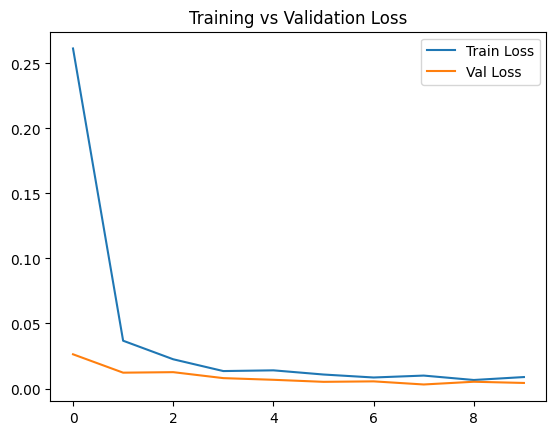

In [6]:
# Evaluate test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.savefig('efficientnet_accuracy.png')
plt.clf()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.savefig('efficientnet_loss.png')


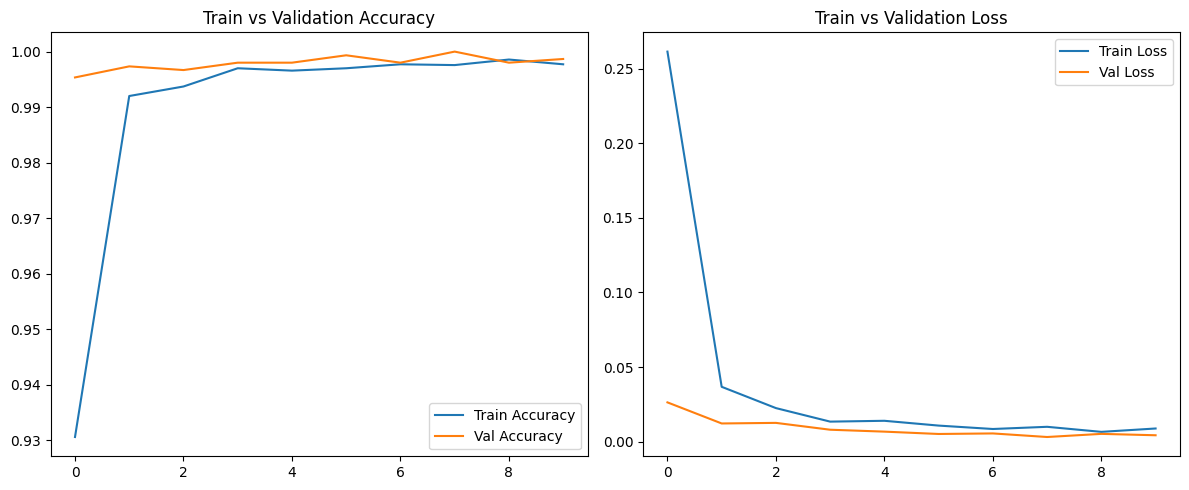

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot and save
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.savefig("accuracy_curve.png")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.savefig("loss_curve.png")

plt.tight_layout()
plt.show()

In [21]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get predictions and labels from test set
y_true = []
y_pred = []

for batch_images, batch_labels in test_ds:
    preds = model.predict(batch_images)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Step 2: Generate classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Step 3: Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Plot confusion matrix using seaborn for better visuals
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - EfficientNet")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("efficientnet_confusion_matrix.png")
plt.close()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━

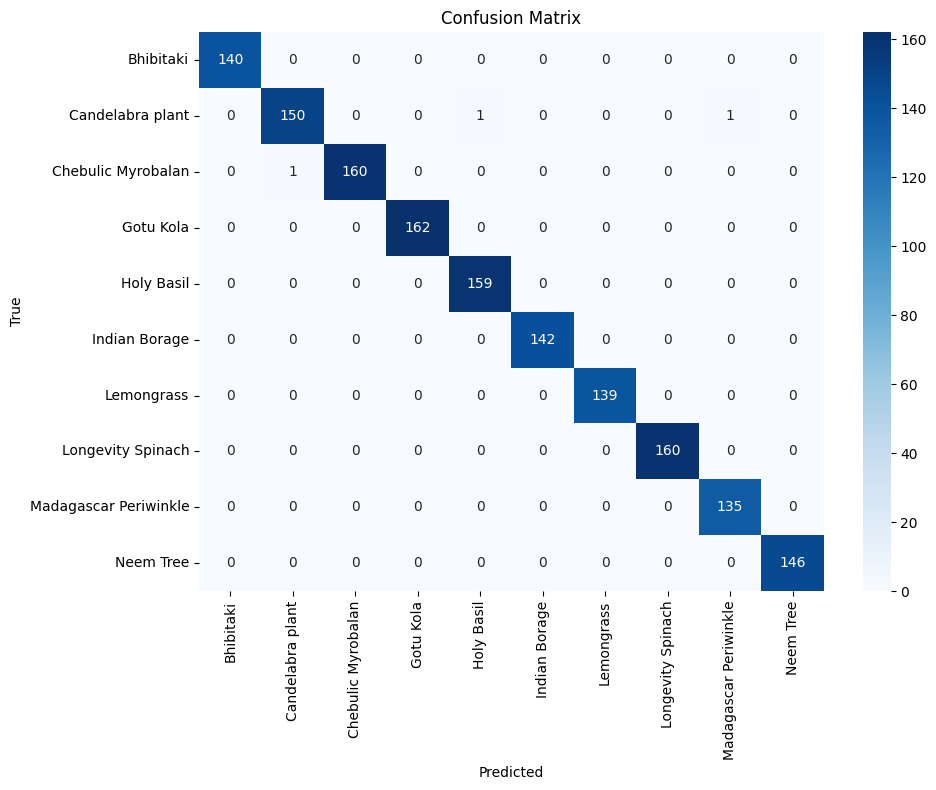

In [22]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

In [23]:
# Save Keras model in .h5 format
model.save("efficientnet_model.h5")
print("✅ Model saved as efficientnet_model.h5")


✅ Model saved as efficientnet_model.h5


In [24]:
# Convert to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the .tflite model
with open("efficientnet_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Model converted and saved as efficientnet_model.tflite")


Saved artifact at '/tmp/tmpeapk4g81'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_238')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140432149015696: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140432149007248: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140433407755088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140433407756432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140433407755472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140433407757200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140433407754512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140433407756048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140433407759120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140433407757776: TensorSpec(shape=(), dtype=tf.resource, name

W0000 00:00:1753898368.100373      36 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1753898368.100408      36 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1753898368.296294      36 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


✅ Model converted and saved as efficientnet_model.tflite
